# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=bffd5c45e59ad3aa9db3e834d4fdf7ee651b708ad4ed7805d4ab01e551f114e1
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=9c42c9f8532f83d04604fd67f8b60923a68ca2166a9c404cab6fbb732881e416
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

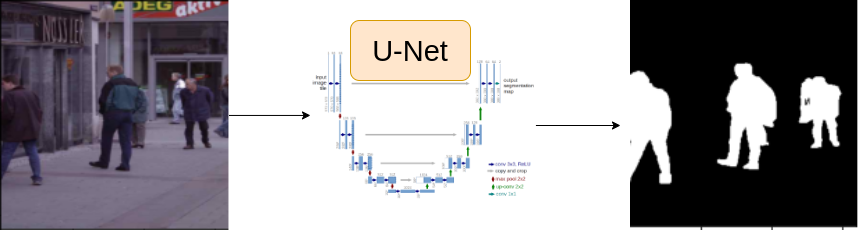

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320 #GIVEN
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head() #mask, images

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]   # eg4
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path) # load image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color spaces, 150+ options

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

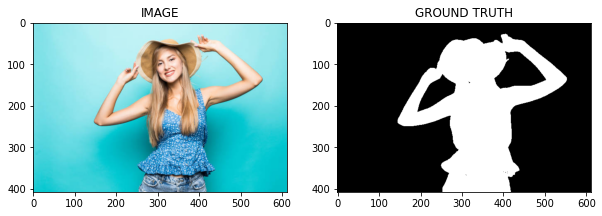

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# split 
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

we apply augmentation on image, not labels.
training, ground truth dataset with masks go through the same augmentation processing. 

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5), # augmentations
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):  
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx): 
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
    mask= np.expand_dims(mask, axis = -1)  # (h, w, c)

    if self.augmentations: 
      data = self.augmentations(image = image, mask = mask ) # return dict format: 
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w) , pytorch format

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0   # scale to be 0-1
    mask = torch.round(torch.Tensor(mask) / 255.0)
    
    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

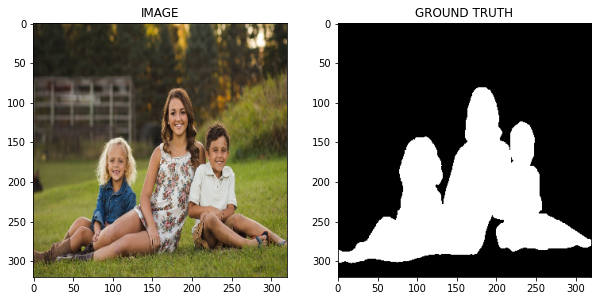

In [ ]:
idx = 38 # eg

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

In [ ]:
for image, mask in trainloader: 
  print(f'One batch image shape : {image.shape}')
  print(f'One batch mask shape : {mask.shape}')
  break; # 1 batch for demo


One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, 
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None): 
    
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer): 

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model): 

  model.eval() #separate, so no dropout
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


SAVED-MODEL
epoch : 1 Train_loss : 0.21342751483122507 Valid_loss : 0.2128732055425644


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


epoch : 2 Train_loss : 0.19388153652350107 Valid_loss : 0.2821548953652382


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


epoch : 3 Train_loss : 0.15673726747433345 Valid_loss : 0.255562711507082


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


epoch : 4 Train_loss : 0.1449128990372022 Valid_loss : 0.2313764989376068


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


epoch : 5 Train_loss : 0.14187944382429124 Valid_loss : 0.2209865115582943


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


SAVED-MODEL
epoch : 6 Train_loss : 0.11479803224404653 Valid_loss : 0.17054160311818123


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


epoch : 7 Train_loss : 0.14584555427233378 Valid_loss : 0.20349840447306633


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


epoch : 8 Train_loss : 0.14831819087266923 Valid_loss : 0.2316022887825966


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


epoch : 9 Train_loss : 0.13099284370740255 Valid_loss : 0.22227191179990768


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


epoch : 10 Train_loss : 0.11927920480569204 Valid_loss : 0.2889641262590885


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


epoch : 11 Train_loss : 0.12975655645132064 Valid_loss : 0.19595970585942268


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


epoch : 12 Train_loss : 0.11432079921166102 Valid_loss : 0.19079501926898956


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


epoch : 13 Train_loss : 0.11932153006394704 Valid_loss : 0.20265131443738937


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


epoch : 14 Train_loss : 0.11169277280569076 Valid_loss : 0.2027132287621498


100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


epoch : 15 Train_loss : 0.09931015819311143 Valid_loss : 0.1856425441801548


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


epoch : 16 Train_loss : 0.0950964813431104 Valid_loss : 0.19655707478523254


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


epoch : 17 Train_loss : 0.09356813679138819 Valid_loss : 0.1789318285882473


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


epoch : 18 Train_loss : 0.10196801722049713 Valid_loss : 0.21643774956464767


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


epoch : 19 Train_loss : 0.1340951551993688 Valid_loss : 0.18564067780971527


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


epoch : 20 Train_loss : 0.11448476364215215 Valid_loss : 0.28690043836832047


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


epoch : 21 Train_loss : 0.1264914609491825 Valid_loss : 0.21690300852060318


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


epoch : 22 Train_loss : 0.1382699544231097 Valid_loss : 0.3386690095067024


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


epoch : 23 Train_loss : 0.21638527164856594 Valid_loss : 0.2668600454926491


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


epoch : 24 Train_loss : 0.1406545917193095 Valid_loss : 0.23919598758220673


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

epoch : 25 Train_loss : 0.12398402839899063 Valid_loss : 0.19580571167171001


# Task 9 : Inference

In [ ]:
idx = 21 # eg

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (1, c, h, w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

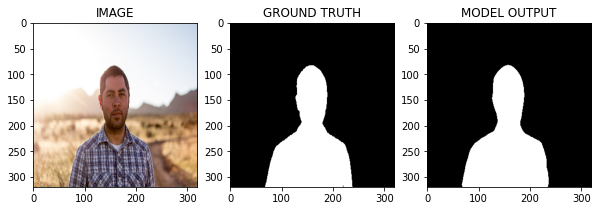

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0) )